In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
from PIL import Image


# Data exploration and pre-processing #


In [3]:
def load_data(image_dir, label_dir):
    image_files = sorted([os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.png')])
    label_files = sorted([os.path.join(label_dir, file) for file in os.listdir(label_dir) if file.endswith('.npy')])
    
    images = [Image.open(file) for file in image_files]
    labels = [np.load(file) for file in label_files]
    
    return np.array(images), np.array(labels)

# Load training and testing data
train_image_dir = 'train/images'
train_label_dir = 'train/labels'
test_image_dir = 'test/images'
test_label_dir = 'test/labels'


X_train, y_train = load_data(train_image_dir, train_label_dir)
X_test, y_test = load_data(test_image_dir, test_label_dir)

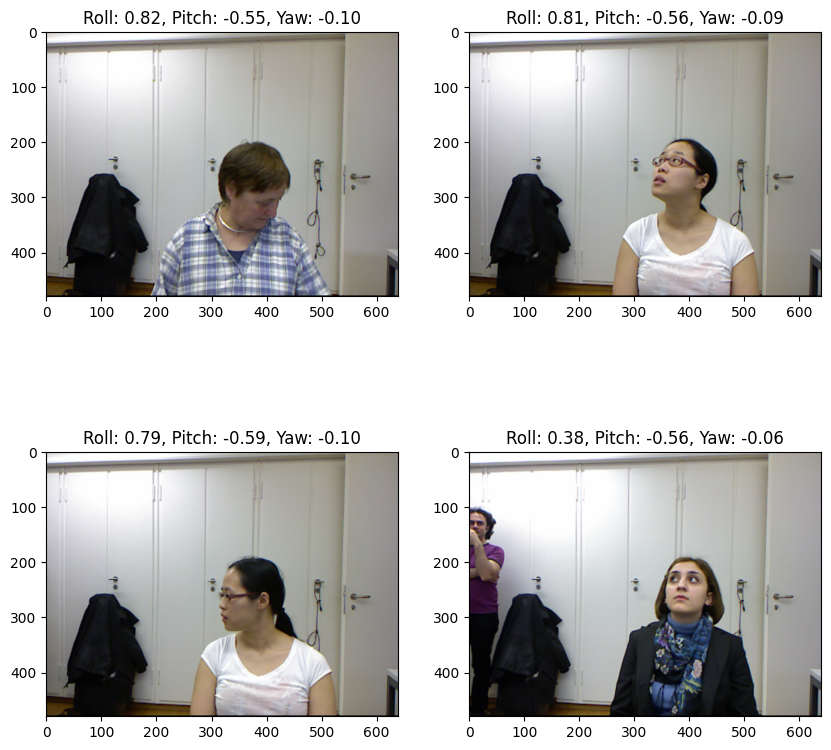

In [22]:
import matplotlib.pyplot as plt

def display_image(images, labels):
    fig = plt.figure(figsize=(10, 10))
    columns = 2 
    rows = 2 
    for i in range(1, rows*columns + 1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(images[i*50])
        plt.title(f'Roll: {labels[i, 0]:.2f}, Pitch: {labels[i, 1]:.2f}, Yaw: {labels[i, 2]:.2f}')
    plt.show()

# Display a sample image and its labels
display_image(X_train, y_train)

# Features extraction #

In [24]:
from skimage.feature import hog
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.transforms import ToTensor, Normalize, Compose
import torch

# HOG Features
def extract_hog_features(images):
    features = [hog(image, pixels_per_cell=(16, 16), cells_per_block=(1, 1), channel_axis=2) for image in images]
    return np.array(features)

resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
resnet.eval()

def extract_resnet_features(images):
    transform = Compose([ToTensor(), Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    with torch.no_grad():
        features = [resnet(transform(image).unsqueeze(0)) for image in images]
    return torch.cat(features).numpy()

# Combine features
X_train_hog = extract_hog_features(X_train)
X_train_resnet = extract_resnet_features(X_train)
X_train_combined = np.hstack((X_train_hog, X_train_resnet))


In [25]:
X_test_hog = extract_hog_features(X_test)
X_test_resnet = extract_resnet_features(X_test)
X_test_combined = np.hstack((X_test_hog, X_test_resnet))

scale image for better results

In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_combined = scaler.fit_transform(X_train_combined)
X_test_combined = scaler.transform(X_test_combined)

# SVM with custom kernels #
kernels inizialization

In [27]:
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def linear_kernel(x, y):
    return np.dot(x, y.T)

def polynomial_kernel(x, y, degree=3, gamma=1, coef0=1):
    return (gamma * np.dot(x, y.T) + coef0) ** degree

def rbf_kernel(x, y, gamma=0.1):
    sq_dists = np.sum((x[:, None] - y) ** 2, axis=2)
    return np.exp(-gamma * sq_dists)

def weighted_kernel_sum(x, y, kernels, w1, w2, w3):
    weights = [w1, w2, w3]
    return sum(weight * kernel(x, y) for kernel, weight in zip(kernels, weights))

def weighted_kernel_product(x, y, kernels, w1, w2, w3):
    kernel_product = 1
    weights = [w1, w2, w3]
    for kernel, weight in zip(kernels, weights):
        kernel_product *= kernel(x, y) ** weight
    return kernel_product

Inizialize kernels to datasets for faster computing

In [28]:
X_train_linear = linear_kernel(X_train_combined, X_train_combined)
X_test_linear = linear_kernel(X_test_combined, X_train_combined)

X_train_poly = polynomial_kernel(X_train_combined, X_train_combined)
X_test_poly = polynomial_kernel(X_test_combined, X_train_combined)

X_train_rbf = rbf_kernel(X_train_combined, X_train_combined, gamma=0.1)
X_test_rbf = rbf_kernel(X_test_combined, X_train_combined, gamma=0.1)

In [29]:
kernels = [linear_kernel, polynomial_kernel, rbf_kernel]
X_train_sum = weighted_kernel_sum(X_train_combined, X_train_combined, kernels, 0.3, 0.3, 0.3)
X_test_sum = weighted_kernel_sum(X_test_combined, X_train_combined, kernels, 0.3, 0.3, 0.3)

The weighted kernel product \( K \) for data points \( x \) and \( y \) is given by:

\[
K(x, y) = \prod_{i=1}^n K_i(x, y)^{w_i}
\]

Where:
- \( K_i \) is the ith kernel function,
- \( w_i \) is the weight associated with the ith kernel,
- \( n \) is the number of kernels being combined.


In [30]:
X_train_product = weighted_kernel_product(X_train_combined, X_train_combined, kernels, 1, 1, 1)
X_test_product = weighted_kernel_product(X_test_combined, X_train_combined, kernels, 1, 1, 1)

# Model evaluation and grid search of hyperparameters #

In [35]:
scoring = {'MAE': 'neg_mean_absolute_error', 'MSE': 'neg_mean_squared_error', 'R2': 'r2'}
param_grid_linear = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
param_grid_poly = {
    'C': [1, 10, 100, 1000],
    'degree': [2, 3, 4, 5],
    'gamma': [0.001, 0.005, 0.01, 0.1, 1],
    'coef0': [0, 0.25, 0.5, 1, 2]
}
param_grid_rbf = {
    'C': [0.01, 0.1, 1, 10],
    'gamma': [0.0001, 0.001, 0.005, 0.01, 0.1, 1, 10]
}

param_grid_sum = {'C': [0.01, 0.1, 1, 5, 10]}
param_grid_product = {'C': [0.01, 0.1, 1, 5, 10]}

cl = {0: "roll", 1 : "pitch", 2 : "yaw"}

best_results = {
    "linear": {"roll": 0, "pitch": 0, "yaw" : 0}, 
    "poly": {"roll": 0, "pitch": 0, "yaw" : 0}, 
    "rbf" : {"roll": 0, "pitch": 0, "yaw" : 0},
    "sum" :{"roll": 0, "pitch": 0, "yaw" : 0},
    "product" : {"roll": 0, "pitch": 0, "yaw" : 0}
            }

for i in range(3):
    # Grid search for linear kernel
    grid_search_linear = GridSearchCV(SVR(kernel='precomputed'), param_grid_linear, cv=5, scoring=scoring, refit="MAE")
    grid_search_linear.fit(X_train_linear, y_train[:, i])
    best_results["linear"][cl[i]]= (grid_search_linear.best_estimator_, -grid_search_linear.best_score_)
    print(f"Linear kernel for {cl[i]}:", grid_search_linear.best_params_, "with score", -grid_search_linear.best_score_)

    # Grid search for polynomial kernel
    grid_search_poly = GridSearchCV(SVR(kernel='precomputed'), param_grid_poly, cv=5, scoring=scoring, refit="MAE")
    grid_search_poly.fit(X_train_poly, y_train[:, i])
    best_results['poly'][cl[i]] = (grid_search_poly.best_estimator_, -grid_search_poly.best_score_)
    print(f"Plynomial kernel for {cl[i]}:", grid_search_poly.best_params_, "with score", -grid_search_poly.best_score_)

    # Grid search for rbf kernel
    grid_search_rbf = GridSearchCV(SVR(kernel='precomputed'), param_grid_rbf, cv=5, scoring=scoring, refit="MAE")
    grid_search_rbf.fit(X_train_rbf, y_train[:, i])
    best_results['rbf'][cl[i]] = (grid_search_rbf.best_estimator_, -grid_search_rbf.best_score_)
    print(f"RBF kernel for {cl[i]}:", grid_search_rbf.best_params_, "with score", -grid_search_rbf.best_score_)

    # ________________________________________________________________________________
    # Do grid search like this, because grid search that is shown below doesnt work 
    # Grid search for sum kernel
    grid_search_rbf = GridSearchCV(SVR(kernel='precomputed'), param_grid_rbf, cv=5, scoring=scoring, refit="MAE")
    grid_search_rbf.fit(X_train_sum, y_train[:, i])
    best_results['sum'][cl[i]] = (grid_search_rbf.best_estimator_, -grid_search_rbf.best_score_)
    print(f"Combined sum of kernels for {cl[i]}:", grid_search_rbf.best_params_, "with score", -grid_search_rbf.best_score_)

    # Grid search for product kernel
    grid_search_rbf = GridSearchCV(SVR(kernel='precomputed'), param_grid_rbf, cv=5, scoring=scoring, refit="MAE")
    grid_search_rbf.fit(X_train_product, y_train[:, i])
    best_results['product'][cl[i]] = (grid_search_rbf.best_estimator_, -grid_search_rbf.best_score_)
    print(f"Combined product of kernel for {cl[i]}:", grid_search_rbf.best_params_, "with score", -grid_search_rbf.best_score_)


Linear kernel for roll: {'C': 0.001} with score 0.36231880498076763
Plynomial kernel for roll: {'C': 1, 'coef0': 0, 'degree': 2, 'gamma': 0.001} with score 0.3686052232041607
RBF kernel for roll: {'C': 0.01, 'gamma': 0.0001} with score 0.4080234511699592
Combined sum of kernels for roll: {'C': 0.01, 'gamma': 0.0001} with score 0.3686064333562328
RBF kernel for roll: {'C': 0.01, 'gamma': 0.0001} with score 0.4088891937057843
Linear kernel for pitch: {'C': 0.001} with score 0.28008246410271714
Plynomial kernel for pitch: {'C': 1, 'coef0': 0, 'degree': 2, 'gamma': 0.001} with score 0.3073837545855387
RBF kernel for pitch: {'C': 0.1, 'gamma': 0.0001} with score 0.3431662450156175
Combined sum of kernels for pitch: {'C': 0.01, 'gamma': 0.0001} with score 0.30738313861135386
RBF kernel for pitch: {'C': 0.01, 'gamma': 0.0001} with score 0.3479991341849912
Linear kernel for yaw: {'C': 0.001} with score 0.16061342420108454
Plynomial kernel for yaw: {'C': 1, 'coef0': 0, 'degree': 2, 'gamma': 0.0

For combined kernels I also wanted to apply grid search, but it doesnt work with function parameters such as w1, w2, w3. Therefore I tried to implement in by myself, but it didnt work :(

In [ ]:
param_grid_sum = {'C': [0.01, 0.1, 1]}
param_grid_product = {'C': [0.01, 0.1, 1, ]}
kernels = [linear_kernel, polynomial_kernel, rbf_kernel]

best_res_comb = {
    "roll": {"sum" : [],"product" : []},
    "pitch": {"sum" : [],"product" : []},
    "yaw": {"sum" : [],"product" : []}
    }
weight_s_1 = [0, 0.1, 0.2, 0.3]
weight_s_2 = [0, 0.1, 0.2, 0.3]
weight_s_3 = [0, 0.1, 0.2, 0.3]

weight_p_1 = [0, 1, 2, 3, 4]
weight_p_2 = [0, 1, 2, 3, 4]
weight_p_3 = [0, 1, 2, 3, 4]
for i in range(3):
    # Grid search for combined kernels_sum
    for w1 in weight_s_1:
        for w2 in weight_s_2:
            for w3 in weight_s_3:
                sum_kerner = lambda x, y : weighted_kernel_sum(x, y, kernels, w1, w2, w3)
                grid_search_sum = GridSearchCV(SVR(kernel=sum_kerner), param_grid_sum, cv=5, scoring='neg_mean_squared_error')
                grid_search_sum.fit(X_train_sum, y_train[:, i])
                best_res_comb[cl[i]]['sum'].append((grid_search_sum.best_estimator_, -grid_search_sum.best_score_))
                print(f"Kernels sum for {cl[i]}:", grid_search_sum.best_params_, "with score", -grid_search_sum.best_score_)

for i in range(3):
     # Grid search for combined kenrels product
    for w1 in weight_p_1:
        for w2 in weight_p_2:
            for w3 in weight_p_3:
                prod_kernel = lambda x, y: weighted_kernel_product(x, y, kernels, w1, w2, w3)
                grid_search_product = GridSearchCV(SVR(kernel=prod_kernel), param_grid_product, cv=5, scoring="neg_mean_squared_error")
                grid_search_product.fit(X_train_product, y_train[:, i]) 
                best_res_comb[cl[i]]['product'].append((grid_search_product.best_estimator_ , -grid_search_product.best_score_)) 
                print(f"Kernels product for {cl[i]}:", grid_search_product.best_params_, "with score", -grid_search_product.best_score_)

   

In [58]:
best_model_roll = best_results['linear']['roll'][0]
best_model_pitch = best_results["linear"]['pitch'][0]
best_model_yaw = best_results['rbf']['yaw'][0]

In [ ]:
predictions_roll = best_model_roll.predict(X_test_linear)
mae = mean_absolute_error(y_test[:, 0], predictions_roll)
mse = mean_squared_error(y_test[:, 0], predictions_roll)
rmse = np.sqrt(mse)
r2 = r2_score(y_test[:, 0], predictions_roll)

print("Metrics for roll")
print(f"Test MAE: {mae}")
print(f"Test RMSE: {rmse}")
print(f"Test R^2: {r2}")
print("---------------------------")

"""
Metrics for roll
Test MAE: 0.16446106798525387
Test RMSE: 0.21066907479105398
Test R^2: 0.8159178100694495
"""

